# **Tâche 2 : Exploration & Analyse**

Objectifs

Cette tâche vise à tester la capacité des candidats à transformer un dataset consolidé en un support d’analyse riche et pertinent, en combinant rigueur statistique, créativité analytique et préparation pour un usage décisionnel (Power BI).

Les candidats devront démontrer leur maîtrise de l’analyse exploratoire, la détection d’anomalies, la création d’indicateurs dérivés, et la structuration de données prêtes pour un tableau de bord interactif.

Missions

- Explorer les données
- Réaliser une analyse descriptive approfondie pour mettre en évidence:
les tendances historiques (ex. évolution démographique, évolution du PIB, scolarisation),
les dynamiques spatiales (variations entre régions, départements, communes).
- Identifier et documenter des corrélations croisées
- Détecter les anomalies et incohérences :
- Créer de nouvelles variables et indicateurs
- Construire des indicateurs avancés tels que :

taux : croissance annuelle de la population

ratios : population jeune.

indices composites : indicateur de développement régional.

Produire des agrégations temporelles et spatiales :
agrégations par département ou région, normalisation par habitant.

Livrables :

Dataset enrichi avec variables calculées et mis à disposition sur un GIT ou Drive
Notebook ou rapport intermédiaire d’analyse.
Liste documentée des anomalies et choix méthodologiques.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
benin_df = pd.read_parquet("./Donnees_ben_pop.parquet")
benin_df.head(3)

,Année,Population 1er Juin,Population Masculine 1er Juin,Population Féminine 1er Juin,Naissances,Décès,Espérance de vie à la naissance,Solde migratoire,Taux de migration net,PIB_prix_constant,Population 0-14,Population 15-59,Population 60+
0,1962.0,2604.659,1236.778,1367.880,122.713,71.049,39.643,-4.844,-1.860,9.910000e+11,1039.7865,1337.6690,227.2030
1,1963.0,2652.908,1261.327,1391.581,125.726,71.212,40.081,-4.847,-1.827,1.110000e+12,1070.0615,1355.3845,227.4620
2,1964.0,2704.003,1287.274,1416.729,128.765,71.412,40.502,-4.839,-1.790,1.190000e+12,1102.3680,1373.6455,227.9895


# Descriptives statistiques

In [3]:
def nuage_de_points(x:str, y: str, donnees: pd.DataFrame, x_label = None, y_label = None):
    if x in donnees.columns and y in donnees.columns:
        plt.scatter(x=x, y=y, data=donnees)
        if y_label :
            plt.ylabel(y_label)
        else:
            plt.ylabel(y)
        plt.xlabel(x)
        plt.title(f"Evolution de ({y}) selon ({x})")
        plt.show()
    else:
        print(f"Une des ou toutes les colonnes ({x} et {y}) n'existent pas dans la base.")

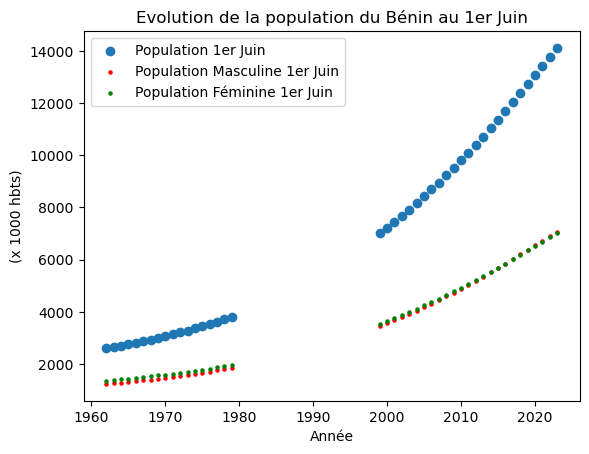

In [4]:
plt.scatter(x = "Année", y="Population 1er Juin", data=benin_df)
plt.scatter("Année", "Population Masculine 1er Juin", data=benin_df, c = "red", s = 5)
plt.scatter("Année", "Population Féminine 1er Juin", data=benin_df, c = "green", s = 5)
plt.title("Evolution de la population du Bénin au 1er Juin")
plt.xlabel("Année")
plt.ylabel("(x 1000 hbts)")
plt.legend()
plt.show()

PIB par habitant

In [5]:
benin_df["PIB par hab"] = benin_df["PIB_prix_constant"]*0.001/benin_df["Population 1er Juin"]

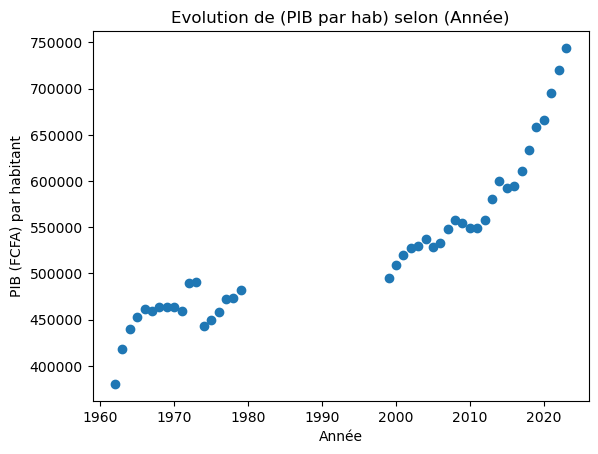

In [6]:
nuage_de_points(y="PIB par hab", x = "Année", donnees=benin_df, y_label="PIB (FCFA) par habitant")

In [7]:
benin_df.dtypes

Année                              float64
Population 1er Juin                float64
Population Masculine 1er Juin      float64
Population Féminine 1er Juin       float64
Naissances                         float64
Décès                              float64
Espérance de vie à la naissance    float64
Solde migratoire                   float64
Taux de migration net              float64
PIB_prix_constant                  float64
Population 0-14                    float64
Population 15-59                   float64
Population 60+                     float64
PIB par hab                        float64
dtype: object

{'whiskers': [<matplotlib.lines.Line2D at 0x2030ab69090>,
 'caps': [<matplotlib.lines.Line2D at 0x2030ab69310>,
 'boxes': [<matplotlib.lines.Line2D at 0x2030ab68f50>],
 'medians': [<matplotlib.lines.Line2D at 0x2030ab69590>],
 'fliers': [<matplotlib.lines.Line2D at 0x2030ab696d0>],
 'means': []}

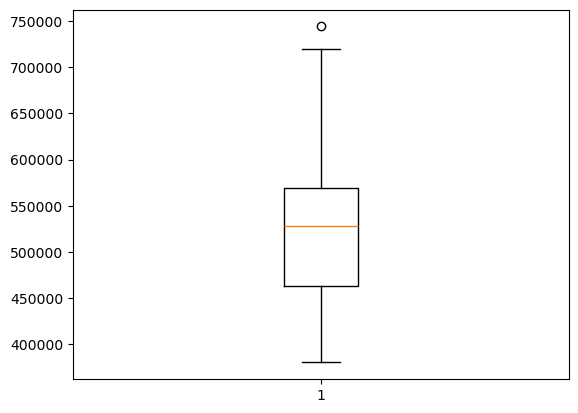

In [8]:
plt.boxplot(x="PIB par hab", data=benin_df)

In [9]:
benin_df.columns

Index(['Année', 'Population 1er Juin', 'Population Masculine 1er Juin',
       'Population Féminine 1er Juin', 'Naissances', 'Décès',
       'Espérance de vie à la naissance', 'Solde migratoire',
       'Taux de migration net', 'PIB_prix_constant', 'Population 0-14',
       'Population 15-59', 'Population 60+', 'PIB par hab'],
      dtype='object')

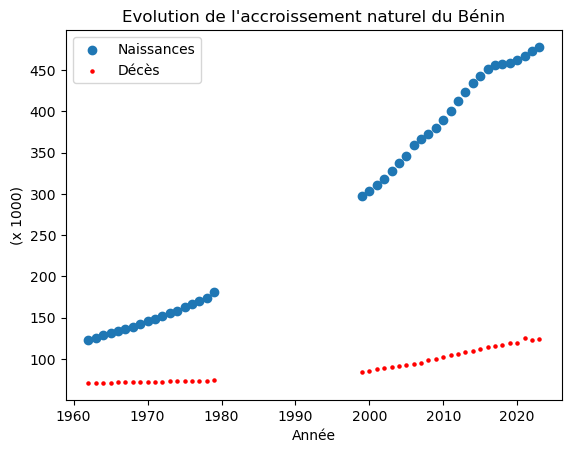

In [12]:
plt.scatter(x = "Année", y="Naissances", data=benin_df)
plt.scatter("Année", "Décès", data=benin_df, c = "red", s = 5)
# plt.scatter("Année", "Solde migratoire", data=benin_df, c = "green", s = 5)
plt.title("Evolution de l'accroissement naturel du Bénin")
plt.xlabel("Année")
plt.ylabel("(x 1000)")
plt.legend()
plt.show()

# Calculs

Ratio de population Jeune

In [14]:
benin_df["Ratio Pop Jeunes"] = benin_df["Population 0-14"]*100/benin_df[["Population 0-14",
                                                                     "Population 15-59",
                                                                     "Population 60+"]].sum(axis=1)

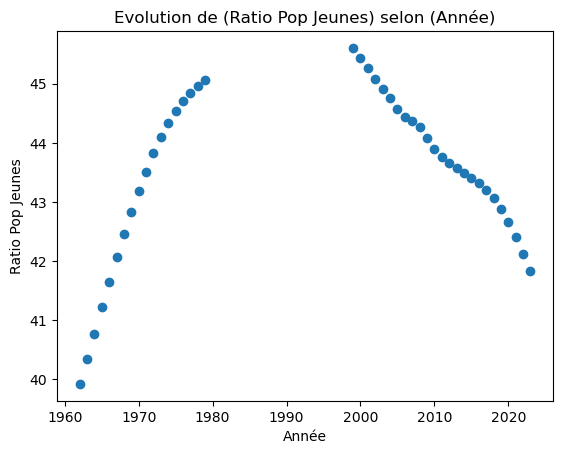

In [16]:
nuage_de_points(x="Année", y="Ratio Pop Jeunes", donnees=benin_df)